# Compass World

In [29]:
using Plots; gr()
using Reproduce
using FileIO
using Statistics
using ProgressMeter
data_home = "../working_results/sweeps"


"../working_results/sweeps"

In [2]:

function get_best_setting(ic, sweep_param, clean_func)

    diff_dict = diff(ic)

    μ = zeros(length(diff_dict[sweep_param]))
    σ = zeros(length(diff_dict[sweep_param]))
    
    for (swprm_idx, swprm) ∈ enumerate(diff_dict[sweep_param])
        _, _, itms = search(ic, Dict(sweep_param=>swprm))
        res = zeros(length(itms))
        for (itm_idx, itm) ∈ enumerate(itms)
            try
                res[itm_idx] = clean_func(
                    load(joinpath(itm.folder_str, "results.jld2")))
                if isnan(res[itm_idx])
                    res[itm_idx] = Inf
                end
            catch
                println("Error")
                res[itm_idx] = Inf
            end
        end
        μ[swprm_idx] = mean(res)
        σ[swprm_idx] = std(res)./sqrt(length(itms))
    end
    min_idx = findmin(μ)
    diff_dict[sweep_param][min_idx[2]], (min_idx[1], σ[min_idx[2]])
end


"""
    get_lines_sensitivity(folder_loc, sens_param, line_params, get_best_func)

Get sensitivity curves over sens_parameters using get_best_Func and line_params. 
# Arguments
-`get_best_func`: A function which takes an itemcollection and returns the best setting. Usually this will be a closure.
- `line_params`: The parameters defining each new line.
- `sens_param`: The x-axis parametere
"""
function get_lines_sensitivity(item_col, sens_param, line_params, get_best_func)

    diff_dict = diff(item_col)
    res_dict = Dict()

    @showprogress 0.1 "Line: " for line_prm ∈ Iterators.product((diff_dict[k] for k ∈ line_params)...)
        sd = Dict(line_params[i]=>line_prm[i] for i ∈ 1:length(line_params))
        _, _, _sub_itms = search(item_col, Dict(line_params[i]=>line_prm[i] for i ∈ 1:length(line_params)))
        sub_ic = ItemCollection(_sub_itms)
        sub_diff_dict = diff(sub_ic)
        μ = zeros(length(sub_diff_dict[sens_param]))
        σ = zeros(length(sub_diff_dict[sens_param]))
        for (sprm_idx, sprm) ∈ enumerate(sub_diff_dict[sens_param])
            _, _, sprm_items = search(sub_ic, Dict(sens_param=>sprm))
            _sprm_ic = ItemCollection(sprm_items)
            prm, (μ[sprm_idx], σ[sprm_idx]) = get_best_func(_sprm_ic)
        end
        res_dict[line_prm] = (μ, σ)
    end
    res_dict, diff_dict[sens_param]
end

get_lines_sensitivity(folder_str::AbstractString, sens_param, line_params, get_best_func) =
    get_lines_sensitivity(ItemCollection(folder_str), sens_param, line_params, get_best_func)

function plot_sensitivity(folder_loc_or_ic, sens_param, line_params, get_best_func, settings_dict=nothing; kwargs...)
    
    res_dict, x_axis = get_lines_sensitivity(folder_loc_or_ic, sens_param, line_params, get_best_func)
    kys = collect(keys(res_dict))
    
    if settings_dict isa Nothing
        settings_dict = Dict(k=>[:label=>"$k"] for k ∈ kys)
    end
    
    plt = if settings_dict isa Nothing
        plot(x_axis, res_dict[kys[1]][1], ribbon=res_dict[kys[1]][2]; kwargs...)
    else
        plot(x_axis, res_dict[kys[1]][1], ribbon=res_dict[kys[1]][2]; settings_dict[kys[1]]..., kwargs...)
    end
    for k ∈ kys[2:end]
        if settings_dict isa Nothing
            plot!(plt, x_axis, res_dict[k][1], ribbon=res_dict[k][2])
        else
            plot!(plt, x_axis, res_dict[k][1], ribbon=res_dict[k][2]; settings_dict[k]...)
        end
    end
    plt
end

function get_x_axis(key, res_dicts, xaxises)
    for (rd_idx, rd) in enumerate(res_dicts)
        if key ∈ keys(rd)
            return xaxises[rd_idx]
        end
    end
end


function plot_sensitivity(res_dict::Dict, x_axis::AbstractArray, settings_dict=nothing; kwargs...)
    x_axis_d = Dict(k=>x_axis for k in keys(res_dict))
    plot_sensitivity(res_dict, x_axis_d, settings_dict; kwargs...)
end


function plot_sensitivity(res_dicts::Tuple, x_axises::Tuple, settings_dict=nothing; kwargs...)
    res_dict = merge(res_dicts...)
    x_axis_d = Dict(k=>get_x_axis(k, res_dicts, x_axises) for k in keys(res_dict))
    plot_sensitivity(res_dict, x_axis_d, settings_dict; kwargs...)
end



function plot_sensitivity(res_dict::Dict, x_axis_d::Dict, settings_dict=nothing;kwargs...)


    kys = collect(keys(res_dict))
    
    if settings_dict isa Nothing
        settings_dict = Dict(k=>[:label=>"$k"] for k ∈ kys)
    end

    plt = plot(x_axis_d[kys[1]], res_dict[kys[1]][1], ribbon=res_dict[kys[1]][2]; settings_dict[kys[1]]..., kwargs...)
    for k ∈ kys[2:end]
        plot!(plt, x_axis_d[k], res_dict[k][1], ribbon=res_dict[k][2]; settings_dict[k]...)
    end
    plt
end

plot_sensitivity (generic function with 8 methods)

In [3]:
function compassworld_sens(ic_rnn, ic_gvfn, hidden)
    sub_ic_rnn = ItemCollection(search(ic_rnn, Dict("hidden"=>hidden))[3])

    rnn_res, x_axis_ro = get_lines_sensitivity(sub_ic_rnn, "truncation", ["cell"], best_func("alpha", "all"))
    gvfn_res, x_axis_go = get_lines_sensitivity(ic_gvfn, "truncation", ["gvfn-horde"], best_func("alpha", "all"))

    plt = plot_sensitivity((rnn_res, gvfn_res), (x_axis_ro, x_axis_go), title="All", lw=2)

    rnn_res, x_axis_ro = get_lines_sensitivity(sub_ic_rnn, "truncation", ["cell"], best_func("alpha", "end"))
    gvfn_res, x_axis_go = get_lines_sensitivity(ic_gvfn, "truncation", ["gvfn-horde"], best_func("alpha", "end"))

    plt2 = plot_sensitivity((rnn_res, gvfn_res), (x_axis_ro, x_axis_go), title="End", lw=2)

    plot(plt, plt2, layout=(2, 1), size=(800, 600), plot_title="Compass World")
end

compassworld_sens (generic function with 1 method)

In [4]:
best_func(best_param, res_key) = (i2c)->get_best_setting(i2c, best_param, (d)->d["results"][res_key])

best_func (generic function with 1 method)

In [5]:
ic_rnn = ItemCollection(joinpath(data_home, "compassworld_rnn/data"));
ic_gvfn = ItemCollection(joinpath(data_home, "compassworld_gvfn/data"));

In [6]:
diff(ic_rnn)

Dict{String,Array} with 5 entries:
  "hidden"     => [35, 40, 110]
  "alpha"      => [0.00877915, 0.0131687, 0.0197531, 0.0296296, 0.0444444, 0.06…
  "truncation" => [1, 4, 8, 12, 16, 24, 32]
  "seed"       => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  "cell"       => ["ARNN", "GRU", "LSTM"]

Line: 100%|█████████████████████████████████████████████| Time: 0:00:06
Line: 100%|█████████████████████████████████████████████| Time: 0:00:07
Line: 100%|█████████████████████████████████████████████| Time: 0:00:02
Line: 100%|█████████████████████████████████████████████| Time: 0:00:02


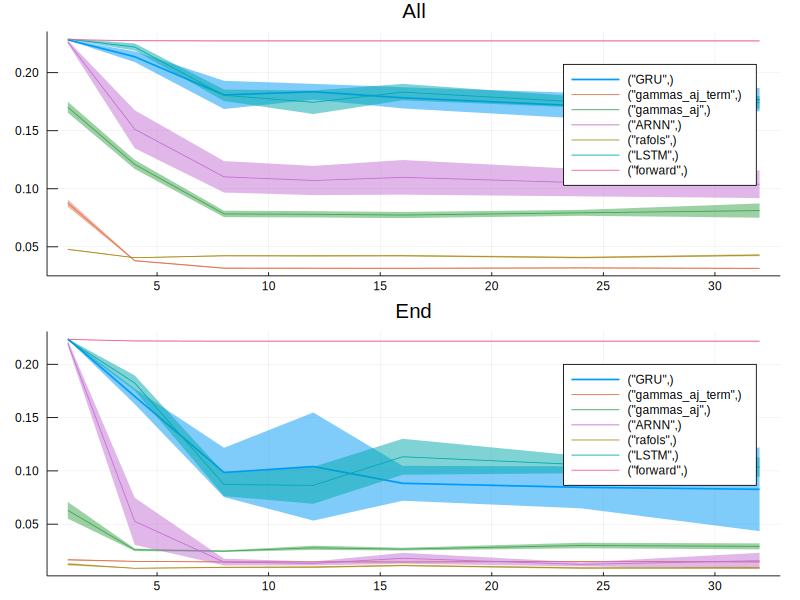

In [7]:
compassworld_sens(ic_rnn, ic_gvfn, 35)

Line: 100%|█████████████████████████████████████████████| Time: 0:00:21
Line: 100%|█████████████████████████████████████████████| Time: 0:00:03
Line: 100%|█████████████████████████████████████████████| Time: 0:00:01
Line: 100%|█████████████████████████████████████████████| Time: 0:00:01


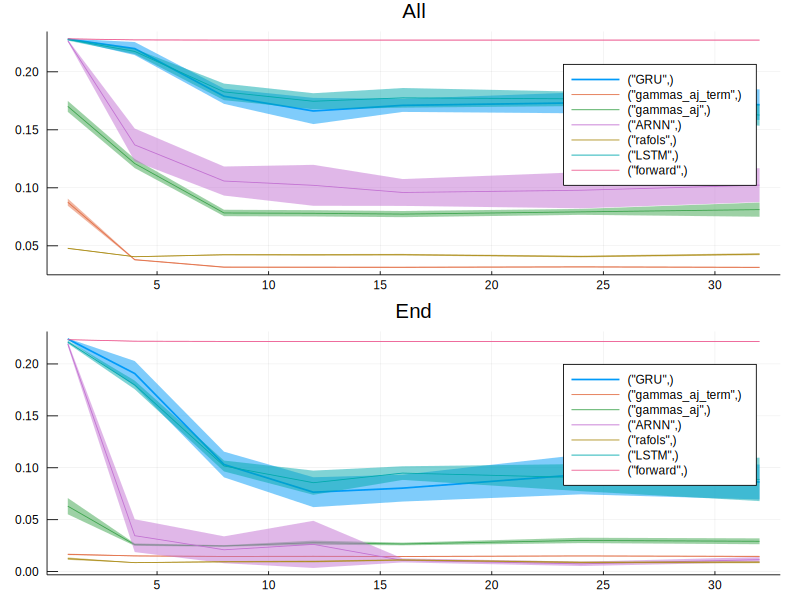

In [8]:
compassworld_sens(ic_rnn, ic_gvfn, 40)

Line: 100%|█████████████████████████████████████████████| Time: 0:00:40
Line: 100%|█████████████████████████████████████████████| Time: 0:00:02
Line: 100%|█████████████████████████████████████████████| Time: 0:00:01
Line: 100%|█████████████████████████████████████████████| Time: 0:00:01


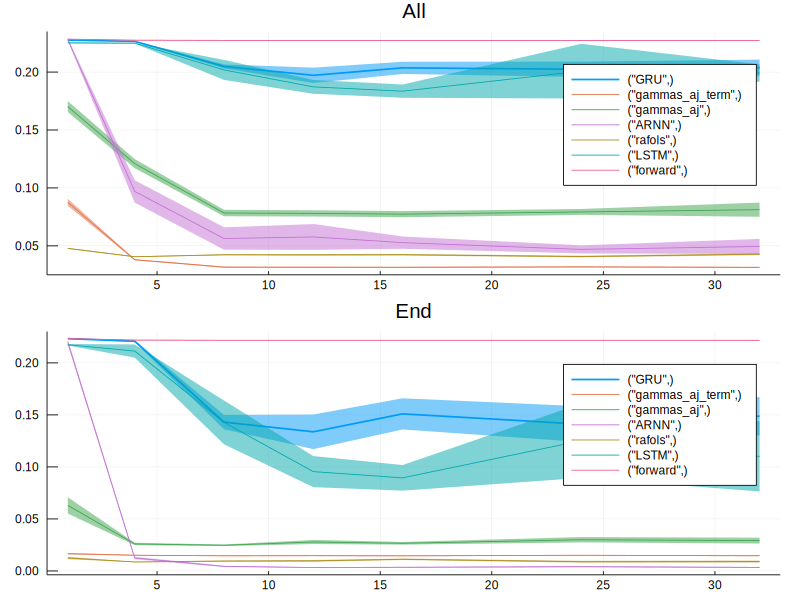

In [9]:
compassworld_sens(ic_rnn, ic_gvfn, 110)

In [10]:
ic_rnn_rmsprop= ItemCollection(joinpath(data_home, "compassworld_rnn_rmsprop/data"));
ic_gvfn_rmsprop = ItemCollection(joinpath(data_home, "compassworld_gvfn_rmsprop/data"));

In [11]:
length(diff(ic_rnn_rmsprop)["alpha"])

6

Line: 100%|█████████████████████████████████████████████| Time: 0:00:04
Line: 100%|█████████████████████████████████████████████| Time: 0:00:06
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00


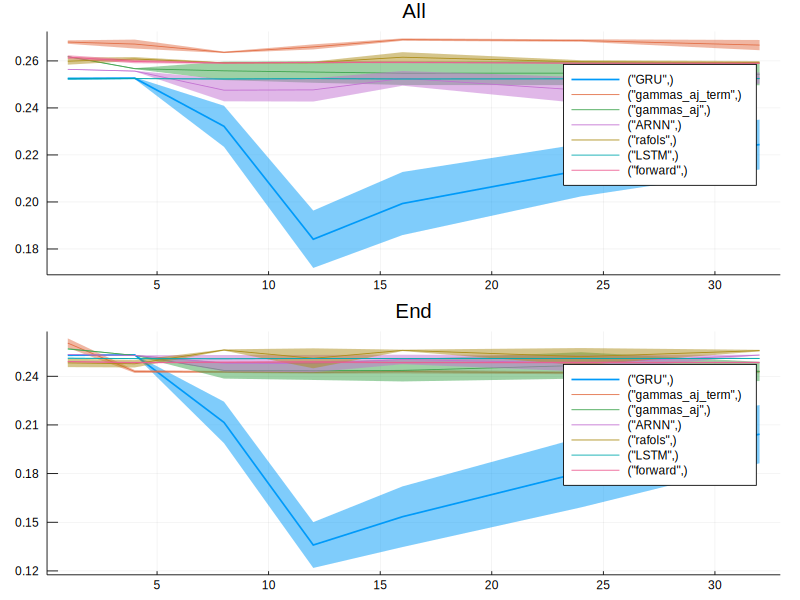

In [12]:
compassworld_sens(ic_rnn_rmsprop, ic_gvfn_rmsprop, 35)

Line: 100%|█████████████████████████████████████████████| Time: 0:00:03
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00


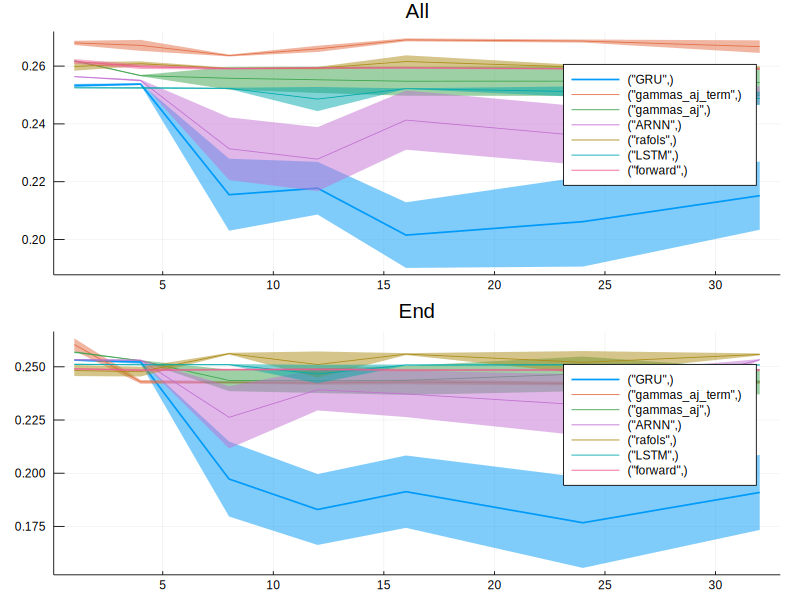

In [13]:
compassworld_sens(ic_rnn_rmsprop, ic_gvfn_rmsprop, 40)

Line: 100%|█████████████████████████████████████████████| Time: 0:00:03
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00


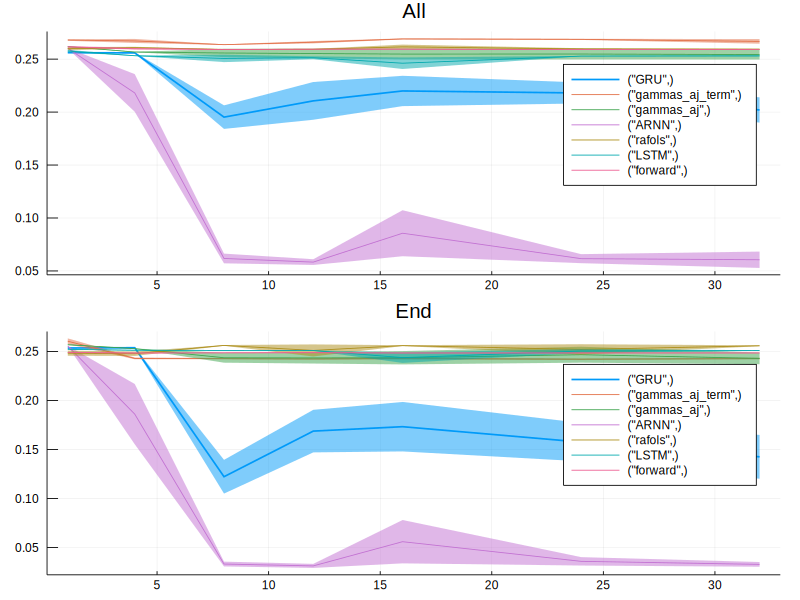

In [14]:
compassworld_sens(ic_rnn_rmsprop, ic_gvfn_rmsprop, 110)

# Adam

In [30]:
ic_rnn_adam = ItemCollection(joinpath(data_home, "compassworld_rnn_adam/data"));
ic_gvfn_adam = ItemCollection(joinpath(data_home, "compassworld_gvfn_adam/data"));

In [36]:
ic_rnn_adam.items[1].parsed_args

Dict{String,Any} with 16 entries:
  "hidden"     => 110
  "opt"        => "ADAM"
  "steps"      => 1000000
  "_GIT_INFO"  => "0"
  "activation" => "sigmoid"
  "sweep"      => true
  "policy"     => "rafols"
  "alpha"      => 0.000877915
  "size"       => 8
  "out-horde"  => "forward"
  "save_dir"   => "/home/mkschleg/scratch/GVFN/compassworld_rnn_adam/data"
  "_HASH"      => 0x10084cadcdc8fca9
  "truncation" => 8
  "seed"       => 6
  "_SAVE"      => "/home/mkschleg/scratch/GVFN/compassworld_rnn_adam/data/RP_0_…
  "cell"       => "GRU"

Line: 100%|█████████████████████████████████████████████| Time: 0:00:04
Line: 100%|█████████████████████████████████████████████| Time: 0:00:07
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:01


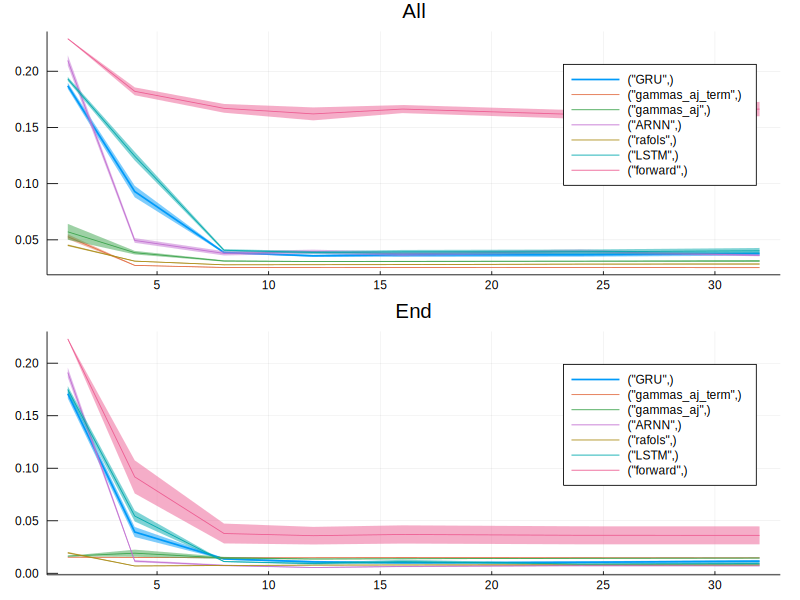

In [31]:
compassworld_sens(ic_rnn_adam, ic_gvfn_adam, 35)

Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:01
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:01


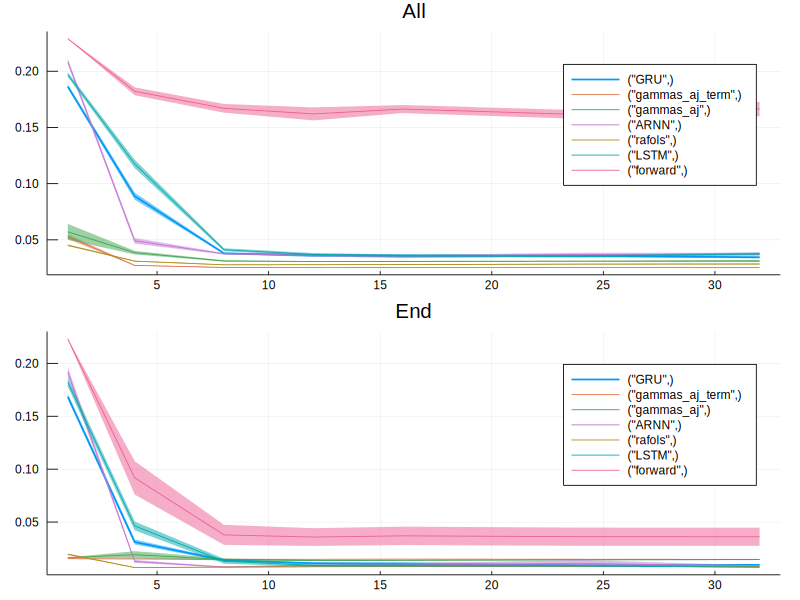

In [33]:
compassworld_sens(ic_rnn_adam, ic_gvfn_adam, 40)

Line: 100%|█████████████████████████████████████████████| Time: 0:00:04
Line: 100%|█████████████████████████████████████████████| Time: 0:00:01
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:01


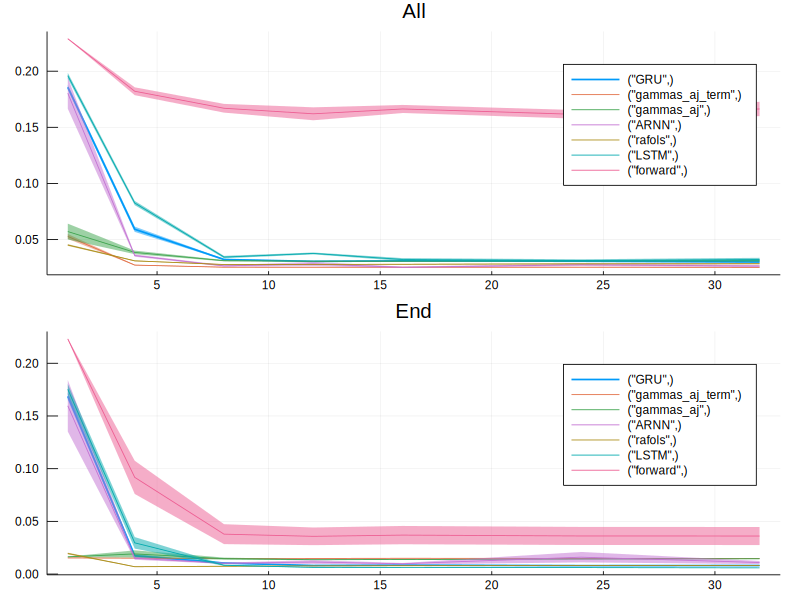

In [34]:
compassworld_sens(ic_rnn_adam, ic_gvfn_adam, 110)